# Quantum Kernel Training for Machine Learning Applications

## Overview
This tutorial demonstrates the training of a quantum kernel on a labeled binary classification dataset. The `Quantum Kernel Alignment` (QKA) will be implemented to train the quantum kernel required by QSVC, a quantum counterpart of the Support Vector Machine (SVM) for solving a binary classification task. 

## Introduction
`Quantum Kernel Alignment` (QKA) is a technique that iteratively adapts a parametrized quantum kernel to a dataset in order to converge to the maximized SVM margin. More information about QKA can be found in the preprint, ["Covariant quantum kernels for data with group structure."](https://arxiv.org/abs/2105.03406)

The entry point to training a quantum kernel is the `QuantumKernelTrainer` class, which will be implemented in accordance to the QKA approach in this tutorial. After training the quantum kernel it is passed into a quantum Support Vector Machine (SVM), these concepts were introduced with more elaboration in the tutorial [Quantum Kernel Machine Learning](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html).

The QML workflow to be implemented is as follows:
1. Prepare the dataset
2. Define the quantum feature map
3. Set up an instance of `TrainableKernel` and `QuantumKernelTrainer` objects
4. Use the `QuantumKernelTrainer.fit` method to train the kernel parameters on the dataset
5. Pass the trained quantum kernel to a machine learning model

### 1. Define a callback class for our optimizer ( a helper function)

In [1]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        A callback function passes information in each iteration step of the SPSA optimizer.
        The information passed in the order in which the arguments are listed
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

### 2. Prepare the Dataset

The dataset will be prepared using Qiskit Machine Learning's `ad_hoc.py` classification dataset to showcase the kernel training process. See the documentation on [ad_hoc data](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html) and the [research paper](https://arxiv.org/pdf/1804.11326.pdf) that popularized the dataset.

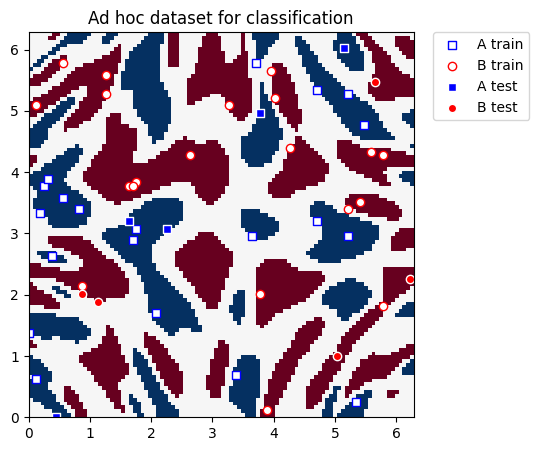

In [2]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
from qiskit_machine_learning.datasets import ad_hoc_data

# Dataset: Ad hoc dataset for classification with 4 classes namely A train, A test, B train and B test.
# The dataset is 2-dimensional
adhoc_dimension = 2

# Split the dataset into train and test
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False,
    one_hot=False,
    include_sample_total=True,
)

# Specify the layout of the plot
plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap="RdBu",
    extent=[0, 2 * np.pi, 0, 2 * np.pi],
)

# Plot Class: A train
plt.scatter(
    X_train[
        np.where(y_train[:] == 0), 0
    ],  # x (index 0) coordinate of train_labels where class is 0 or A
    X_train[
        np.where(y_train[:] == 0), 1
    ],  # y (index 1) coordinate of train_labels where class is 0 or A
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)

# Plot Class: B train
plt.scatter(
    X_train[
        np.where(y_train[:] == 1), 0
    ],  # x (index 0) coordinate of train_labels where class is 1 or B
    X_train[
        np.where(y_train[:] == 1), 1
    ],  # y (index 1) coordinate of train_labels where class is 1 or B
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)

# Plot Class: A test
plt.scatter(
    X_test[
        np.where(y_test[:] == 0), 0
    ],  # x (index 0) coordinate of test_labels where class is 0 or A
    X_test[
        np.where(y_test[:] == 0), 1
    ],  # y (index 1) coordinate of test_labels where class is 0 or A
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)

# Plot Class: B test
plt.scatter(
    X_test[
        np.where(y_test[:] == 1), 0
    ],  # x (index 0) coordinate of test_labels where class is 1 or B
    X_test[
        np.where(y_test[:] == 1), 1
    ],  # y (index 1) coordinate of test_labels where class is 1 or B
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

# Plot the dataset
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset for classification")
plt.show()

### 3. Define the Quantum Feature Map

Next, we set up the quantum feature map, which encodes or maps classical data into the quantum state space. The `ZZFeatureMap` [(link)](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) from `Qiskit` is used to represent the input data. The trainable weights are represented by a `QuantumCircuit` to set up a trainable rotation layer. 

In [3]:
# Required imports
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap
from qiskit.visualization import circuit_drawer

# Create a rotational layer to train. We will rotate each qubit the same amount.
fm0 = QuantumCircuit(2)  # define quantum circuit with 2 qubits
training_params = ParameterVector("θ", 1)  # define "θ" as a pramater to be trained as weight
fm0.ry(training_params[0], 0)  # apply "θ" degree rotation about y axis on qubit 0
fm0.ry(training_params[0], 1)  # apply "θ" degree rotation about y axis on qubit 1

# Use ZZFeatureMap (quantum feature map) to represent input data
fm1 = ZZFeatureMap(2)

# Create the complete feature map by composition of our two circuits (fm0 and fm1)
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params}")

     ┌──────────┐┌──────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                         ├
     ├──────────┤│  ZZFeatureMap(x[0],x[1]) │
q_1: ┤ Ry(θ[0]) ├┤1                         ├
     └──────────┘└──────────────────────────┘
Trainable parameters: θ, ['θ[0]']


### 4. Set Up the Quantum Kernel and Quantum Kernel Trainer

Quantum Kernel Alignment (QKA) technique for training the quantum kernel is implemented by using `TrainableFidelityQuantumKernel` to hold the feature map and its parameters, along with `QuantumKernelTrainer` to manage the training process.

Further, the kernel loss function is selected to be `SVCLoss`, as an input to the `QuantumKernelTrainer`. Since this is a Qiskit-supported loss function, we can use the string, `"svc_loss"`; however, it must be noted that Qiskit uses default settings when passing the loss as a string. For custom settings, instantiation must be  explicitly done with the desired options, followed by passing the `KernelLoss` object to the `QuantumKernelTrainer`.

Finally, we must select the optimizer, in this case `SPSA`, and initialize the trainable parameter with the `initial_point` argument. Note: The length of the list passed as the `initial_point` argument must equal the number of trainable parameters in the feature map.

So to sum it up:
* [TrainableFidelityQuantumKernel](https://github.com/Qiskit/qiskit-machine-learning/blob/main/qiskit_machine_learning/kernels/trainable_fidelity_quantum_kernel.py) holds the feature map and is passed as an argument to QuantumKernelTrainer (OKT)
* [QuantumKernelTrainer](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.algorithms.QuantumKernelTrainer.html) manages the training process
* [SVCLoss](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.utils.loss_functions.SVCLoss.html) is selected as the kernel loss function
* [SPSA](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) is selected as the optimizer

In [4]:
# Required imports
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit.algorithms.optimizers import SPSA

# Instantiate quantum kernel to hold feature map
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Instantiate callback function (helper function) to be passed to the optimizer
cb_qkt = QKTCallback()

# Set up the optimizer
spsa_opt = SPSA(
    maxiter=10,  # maximum number of iterations
    callback=cb_qkt.callback,  # callback function to pass information in each iteration step
    learning_rate=0.05,  # set the learning rate (to be multiplied with gradient at each update)
    perturbation=0.05,  # set the perturbation (a form of disturbance or deviation)
)  # NOTE: leatning_rate and perturbation, both should be specified if any one of them is given.

# Instantiate a quantum kernel trainer to manage the training process
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,  # quantum kernel that holds feature map (TrainableFidelityQuantumKernel)
    loss="svc_loss",  # set loss function to "svc_loss"
    optimizer=spsa_opt,  # set optimizer to SPSA
    initial_point=[
        np.pi / 2
    ],  # The initial point from which the optimizer will begin, set to 90 degrees
)

### 5. Train the Quantum Kernel

To train the quantum kernel on the dataset consisting of samples and labels of classification, we call the `fit` method of `QuantumKernelTrainer`.

The output of `QuantumKernelTrainer.fit` is a `QuantumKernelTrainerResult` object. The resultant object contains the following class fields that give a descriptive summary of the trained model:
 - `optimal_parameters`: A dictionary containing {parameter: optimal value} pairs
 - `optimal_point`: The optimal parameter value found in training
 - `optimal_value`: The value of the loss function at the optimal point
 - `optimizer_evals`: The number of evaluations performed by the optimizer
 - `optimizer_time`: The amount of time taken to perform optimization
 - `quantum_kernel`: A `TrainableKernel` object with optimal values bound to the feature map

In [5]:
# Train the kernel using fit on QKT (QuantumKernelTrainer)
qka_results = qkt.fit(X_train, y_train)
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {ParameterVectorElement(θ[0]): 1.6933004333280843},
    'optimal_point': array([1.69330043]),
    'optimal_value': 15.553089700270306,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x7f0964118220>}


### 6. Fit and Test the Model

It is time to pass the trained quantum kernel to the classification machine learning model, followed by fitting the model on train data and testing on new data. Here, we will use Qiskit's `QSVC` for classification, it was introduced in the tutorial [Quantum Kernel Machine Learning](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html).

In [6]:
# Required imports
from qiskit_machine_learning.algorithms import QSVC
from sklearn import metrics

# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)  # using kernel from QKT

# Fit the model on train data
qsvc.fit(X_train, y_train)

# Test the model on new (test) data

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 1.0


### 7. Visualize the Kernel Training Process

From the callback data collected at each update or optimization step of the iteration, we can plot how the loss evolves during the training process. We see it converges (reduces) rapidly for the sake of accuracy and reaches high test accuracy on the given dataset with the set choice of inputs. We can also display the final kernel matrix, which is a measure of similarity between the training samples.

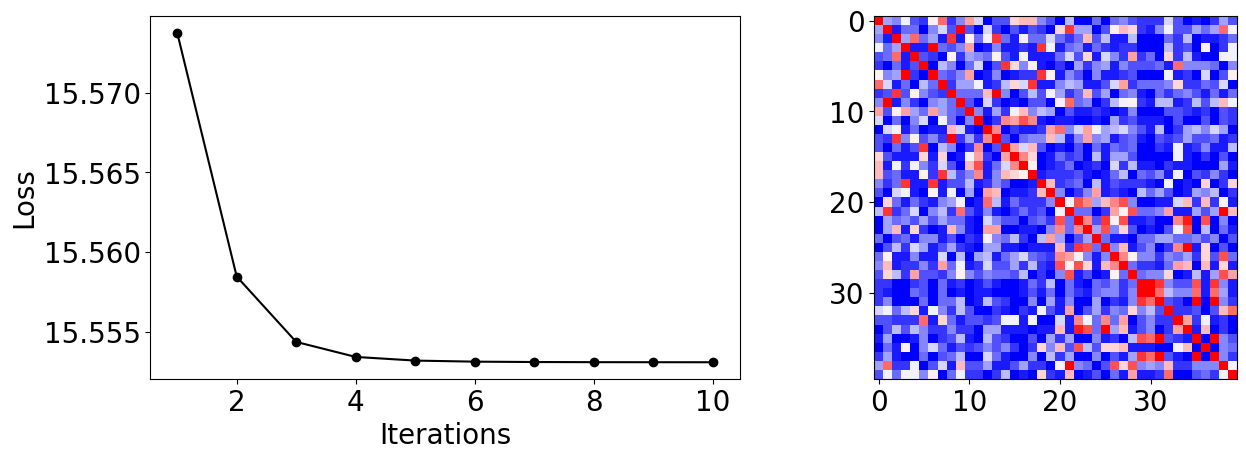

In [7]:
# Required imports
from pylab import cm

# Fetch callback data
plot_data = cb_qkt.get_callback_data()
# Get the kernel matrix evaluated on the training samples
K = optimized_kernel.evaluate(X_train)

# Plot loss (dependent variable shown on y axis) over iterations (independent variable on x axis)
plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")

# Plot the kernel matrix
ax[1].imshow(K, cmap=cm.get_cmap("bwr", 20))
fig.tight_layout()
plt.show()

## What was learned

We learned to implement the complete quantum machine learning workflow in an end-to-end manner. We were able to solve a problem of binary classification using `QSVC`, a quantum Support Vector Machine (SVM) in Qiskit using a quantum kernel developed using the `Quantum Kernel Alignment` (QKA) technique.

In [8]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright